In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # оптимизаторы
from tensorflow.keras.preprocessing.sequence import pad_sequences # ограничение последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # токенизатор
from tensorflow.keras import utils # перевод в OHE
from tensorflow.keras.utils import plot_model # визуализации архитектуры модели

import numpy as np #библиотека для работы с массивами данных
from google.colab import files # модуль для загрузки файлов в colab
from google.colab import drive # подключение Google-диска
import yaml # модуль для удобной работы с файлами
import gc # Управление памятью

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Загрузка диалогов в формате YAML
# Хороший размер датасета - 10000 вопросов и 10000 ответов
dataset = open('/content/drive/MyDrive/Colab Notebooks/Machine_learning/Datasets/dialogs/dialogs.yml') # Открытие файла диалогов в режиме чтения 
document = yaml.safe_load(dataset) # Загрузка файла в кодовое пространство
conversations = document['разговоры'][:10000] # Занесение диалогов в conversations.
# В каждый элемент списка будет занесен 1 вопрос и ответ на него.
# Т.е. там будет 10000 вопросов и ответов, что разделены запятой

# Освобождение памяти
del document
gc.collect()
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[9999])) # Вывод последней информации загруженной из датасета

<class 'list'>
Количество пар вопрос-ответ : 10000
Пример диалога : ['Воры,  грабители  могил.', 'У вас есть корабль?']


In [6]:
# Разделение вопросов и ответов на разные списки

questions = list() # список вопросов
answers = list()   # список ответов

In [7]:
# Проход в цикле по всем парам вопрос-ответ
for con in conversations:
  print(con)
  break
  if len(con) > 2 :          # Объединение ответа состоящего из 2х и более предложений
    questions.append(con[0]) # первый элемент массива - это вопрос
    replies = con[1:]        # все остальные элементы массива - это ответы
    ans = ''
    for rep in replies: # Объединение всех ответов в один через пробел
      ans += ' ' + rep
    answers.append(ans) # Добавление в список ответов
  elif len(con) > 1: # Занесение ответа состоящего из 1 предложения
    questions.append(con[0])
    answers.append(con[1])

['Что,  Мансур,  не жарко теперь тебе?', 'Спрашиваю, не жарко ему теперь?']


In [ ]:
# Очистка строк с неопределенным типом ответов
answersCleaned = list()
questionsCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:  # Сохранение в базу только тех ответов и вопросов, чей тип - строка
    answersCleaned.append(answers[i])
    questionsCleaned.append(questions[i])

# Подмена массива вопросов на очищенный массив вопросов
questions = questionsCleaned

# Освобождение памяти
del questionsCleaned
del conversations
del answers
gc.collect()

127

In [ ]:
# Создание тегов-меток для начала и конца ответов
# Также подмена массива ответов на очищенный массив ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Освобождение памяти
del answersCleaned
gc.collect()

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[1210]))
print('Ответ : {}'.format(answers[1210]))

Вопрос : Пойдешь  проводником?
Ответ : <START> Ну,  решай. <END>


In [ ]:
# Токенизация диалогов

tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers) # Токенизация вопросов и ответов
vocabularyItems = list(tokenizer.word_index.items())
vocabularySize = len(vocabularyItems)+1 # Определение размера словаря

print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('а', 5), ('я', 6), ('ты', 7), ('это', 8), ('в', 9), ('да', 10), ('и', 11), ('как', 12), ('нет', 13), ('вы', 14), ('ну', 15), ('на', 16), ('с', 17), ('же', 18), ('так', 19), ('он', 20), ('где', 21), ('кто', 22), ('у', 23), ('все', 24), ('мы', 25), ('то', 26), ('мне', 27), ('тебя', 28), ('меня', 29), ('почему', 30), ('там', 31), ('здесь', 32), ('есть', 33), ('еще', 34), ('тебе', 35), ('за', 36), ('о', 37), ('вот', 38), ('его', 39), ('куда', 40), ('ничего', 41), ('знаю', 42), ('вас', 43), ('чем', 44), ('она', 45), ('ли', 46), ('чего', 47), ('но', 48), ('вам', 49), ('может', 50)]
Размер словаря : 13355


In [ ]:
# Обработка вопросов

# Перевод текста в коды с помощью токенайзера
tokenizedQuestions = tokenizer.texts_to_sequences(questions)

# Вычисление длины самого длинного вопроса
maxLenQuestions = max([ len(x) for x in tokenizedQuestions ])

# Перевод вопросов к одной длине. Всё лишнее в коротких вопросах заполняется нулями
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Перевод в numpy массив
encoderForInput = np.array(paddedQuestions)

print('Пример оригинального вопроса:    {}'.format(questions[101])) 
print('Пример кодированного вопроса:    {}'.format(encoderForInput[101])) 
print('Размерность входа для нейросети: {}'.format(encoderForInput.shape)) 
print('Максимальная длина вопросов:     {}'.format(maxLenQuestions)) 

Пример оригинального вопроса:    Генерал у себя?
Пример кодированного вопроса:    [235  23 138   0   0   0   0   0   0   0   0]
Размерность входа для нейросети: (9995, 11)
Максимальная длина вопросов:     11


In [ ]:
# Обработка ответов ДЛЯ Encoder

tokenizedAnswers = tokenizer.texts_to_sequences(answers)
maxLenAnswers = max([len(x) for x in tokenizedAnswers] )
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

decoderForInput = np.array(paddedAnswers)

print('Пример оригинального ответа:        {}'.format(answers[101])) 
print('Пример раскодированного ответа:     {}'.format(decoderForInput[101][:30])) 
print('Размерность раскодированны ответов: {}'.format(decoderForInput.shape)) 
print('Максимальная длина ответов:         {}'.format(maxLenAnswers)) 

Пример оригинального ответа:        <START> Ждет вас. <END>
Пример раскодированного ответа:     [  1 710  43   2   0   0   0   0   0   0   0   0   0]
Размерность раскодированны ответов: (9995, 13)
Максимальная длина ответов:         13


*Здесь RAM начинает быстро расходоваться*

In [ ]:
# Обработка ответов ДЛЯ Decoder

tokenizedAnswers = tokenizer.texts_to_sequences(answers)

# Удаление тега <START>
for i in range(len(tokenizedAnswers)) :
  tokenizedAnswers[i] = tokenizedAnswers[i][1:]

paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

# Перевод в one hot vector
oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize)

decoderForOutput = np.array(oneHotAnswers)

In [ ]:
# Вывод примера данных

print('Ответ для Encoder (коды):   {}'.format(decoderForInput[101][:21]))  
print('Ответ для Decoder (OHE):    {}'.format(decoderForOutput[101][2][:21])) 
print('Размерность ответа в OHE :  {}'.format(decoderForOutput.shape))
print('Длина вопросов для Encoder: {}'.format(maxLenAnswers)) 

Ответ для Encoder (коды):   [  1 710  43   2   0   0   0   0   0   0   0   0   0]
Ответ для Decoder (OHE):    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размерность ответа в OHE :  (9995, 13, 13355)
Длина вопросов для Encoder: 13


Нейросеть. Отдельно Encoder и отдельно Decoder

In [ ]:
# Структура н.с. ENCODER

# На этот слой подается encoderForInput
encoderInputs = Input(shape=(None, ))

# Слой Embedding (длина словаря, размерность)
# mask_zero=True - для предотвращения ответов типа: "У меня все хорошо хорошо хорошо хорошо..."
encoderEmbedding = Embedding(vocabularySize, 150, mask_zero=True) (encoderInputs)

# Вывод 3 значений состояния слоем LSTM
encoderOutputs, state_h , state_c = LSTM(150, return_state=True)(encoderEmbedding)

# Взятие только 2х значений состояний
encoderStates = [state_h, state_c]

In [ ]:
# Структура н.с. DECODER

# На этот слой подается decoderForInput
decoderInputs = Input(shape=(None, ))

# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - для предотвращения ответов типа: "У меня все хорошо хорошо хорошо хорошо..."
decoderEmbedding = Embedding(vocabularySize, 150, mask_zero=True) (decoderInputs) 

# Вывод 3 значений состояния слоем LSTM (причем берем не один выход H, а с каждого слова)
decoderLSTM = LSTM(150, return_state=True, return_sequences=True)

# Взятие набора выходов с каждого слоя
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)

# Слой определния слова (слой классификации)
decoderDense = Dense(vocabularySize, activation='softmax') 

# Выход декодера и всей сети
output = decoderDense(decoderOutputs)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 150)    2003250     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 150)    2003250     ['input_2[0][0]']                
                                                                                            

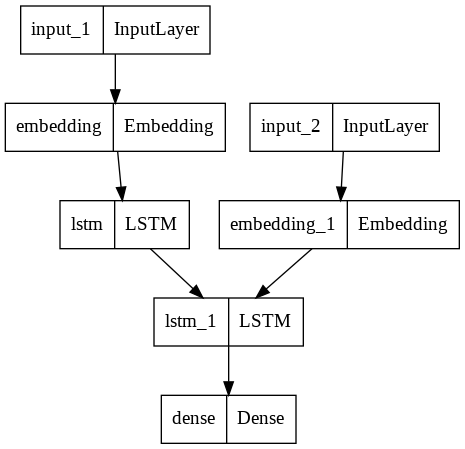

In [ ]:
# Формирование итоговой модели н.с. путём объединения ENCODER и DECODER

model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy') # Какой тут шаг обучения по умолчанию? Как его регулировать?

# Отобразим структуру нейронной сети
print(model.summary())
plot_model(model, to_file='model.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
# Запуск обучения и сохранение весов
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=40) 
model.save( 'text_generation-40.h5' )

Epoch 1/40
200/200 [==============================] - 18s 29ms/step - loss: 2.2696
Epoch 2/40
200/200 [==============================] - 6s 29ms/step - loss: 1.9773
Epoch 3/40
200/200 [==============================] - 6s 29ms/step - loss: 1.9324
Epoch 4/40
200/200 [==============================] - 6s 29ms/step - loss: 1.8981
Epoch 5/40
200/200 [==============================] - 6s 29ms/step - loss: 1.8671
Epoch 6/40
200/200 [==============================] - 6s 29ms/step - loss: 1.8386
Epoch 7/40
200/200 [==============================] - 6s 29ms/step - loss: 1.8115
Epoch 8/40
200/200 [==============================] - 6s 29ms/step - loss: 1.7846
Epoch 9/40
200/200 [==============================] - 6s 28ms/step - loss: 1.7584
Epoch 10/40
200/200 [==============================] - 6s 29ms/step - loss: 1.7310
Epoch 11/40
200/200 [==============================] - 6s 29ms/step - loss: 1.7050
Epoch 12/40
200/200 [==============================] - 6s 29ms/step - loss: 1.6786
Epoch 13/40


Нейросеть для генерирования ответов

In [ ]:
# Создание структуры н.с. для получения ответов слово за словом

def makeInferenceModels():
  # ENCODER

  encoderModel = Model(encoderInputs, encoderStates) # Подача на вход encoderForInputs и предыдущего состояния

  # DECODER

  decoderStateInput_h = Input(shape=(150 ,)) # Обозначение размерности для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(150 ,)) # Обозначение размерности для входного слоя с состоянием state_c
  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # Объединение 2х состояний в 1

  # Взятие ответов, прошедших через эмбединг, вместе с состояниями и их подача в LSTM cлой
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] # Сохранение состояния LSTM для передачи на следующий шаг
  decoderOutputs = decoderDense(decoderOutputs) # Взятие выхода из предыдущей модели

  # На входе декодера далее будут ответы (decoderForInputs) и состояния
  # На выходе декодера будет последовательность слов (кодов слов) и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel, decoderModel

In [ ]:
# Функция преобразования вопроса пользователя в последовательность индексов

def strToTokens(sentence: str): # На вход - вопрос
  words = sentence.lower().split() # вопрос в нижний регистр и разбиение на слова
  tokensList = list() # для хранения последовательности токенов/индексов слов предложения
  for word in words: # Проход по всем словам предложения
    tokensList.append(tokenizer.word_index[word]) # Определение и сохранение индекса слова
    # Здесь можно добавить "защиту от дурака", если слова не окажется в словаре

  # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
# Генерация ответа

encModel, decModel = makeInferenceModels() # Получение энкодера и декодера

for _ in range(6): # Тест нейросети на 6 вопросах

  strTK = strToTokens(input( 'Задайте вопрос : ' )) # Перевод строки пользователя в индексы
  statesValues = encModel.predict(strTK)

  # Создание пустого массива размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # Добавление в пустую последовательность индекса начального слова 'start'

  stopCondition = False # условие, при срабатывании которого, прекратится генерация очередного слова

  decodedTranslation = '' # для сборки генерируемого ответа

  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    # argmax найдет максимальное и вернёт нам индекс слова
    sampledWordIndex = np.argmax(decOutputs[0, 0, :])
    sampledWord = None # создаем переменную, в которую положим слово
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # Создание пустого массива размером (1, 1)
    emptyTargetSeq[0, 0] = sampledWordIndex # Сохранение в него индекса выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  # Вывод ответа сгенерированный нейросетью
  print(decodedTranslation[:-4]+"\n")

Задайте вопрос : ты
 я

Задайте вопрос : ну да
 а я ничего

Задайте вопрос : конечно
 ну хорошо

Задайте вопрос : возможно
 мы бы не имею

Задайте вопрос : это как
 да так

Задайте вопрос : ну вот так
 что вы к вам не

